## Gradient Boosting

In [2]:
# Import required packages for this chapter
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pylab as plt

from dmba import classificationSummary
from dmba import liftChart, gainsChart

%matplotlib inline

no display found. Using non-interactive Agg backend


In [3]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('/Users/ujjwalsharma/207 class/Homework /gradient boosting')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

## To receive credit, all answers must be derived exclusively from the instructor’s lectures, the example code provided by the instructor, and the official course textbook. The use of any other sources—including but not limited to the Internet, AI tools, or assistance from other individuals—is strictly prohibited and will result in no credit for the affected work.

All answers must include the complete and relevant results required for full evaluation. When applicable, set random_state = 1.

### Evaluation Criteria

| Component                    | Description                                                                       | Weight |
| ---------------------------- | --------------------------------------------------------------------------------- | ------ |
| Data preprocessing & setup   | Correct data transformation, partitioning, reproducibility                        | 15%    |
| Model development            | Correct fitting and tuning of single tree, AdaBoost, and Gradient Boosting models | 25%    |
| Model evaluation             | Proper use and interpretation of accuracy, recall, ROC, and feature importance    | 25%    |
| Analytical interpretation    | Clear, original reasoning linking technical results to real-world context         | 25%    |
| Communication & presentation | Professional clarity, structure, and insightfulness                               | 10%    |


# Predicting Delayed Flights
## Objective:
Build and interpret boosted classification models to predict flight delays and evaluate their performance using both technical accuracy and domain insight.

The dataset FlightDelays.csv contains all commercial flights departing the Washington, DC area and arriving in New York during January 2004.
For each flight, you have details such as departure and arrival airports, distance, date and time, and other relevant variables.
A <i>delay</i> is defined as an arrival at least 15 minutes later than scheduled.

## Part 1. Data Preprocessing

Convert the day of week variable into a categorical variable.

Bin the scheduled departure time into eight intervals using pd.cut() from the pandas package.

Partition the data into training (60%) and validation (40%) sets using random_state = 1.

Report the number of delayed vs. on-time flights in each partition, and comment on any imbalance.


Interpretation question:

What potential issues could arise from class imbalance when building classification trees? How might boosting help address them?

In [4]:
# convert the day of week variable into a categorical variable 
df=pd.read_csv(DATA/'FlightDelays.csv')
df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [5]:
df['DAY_WEEK']=df['DAY_WEEK'].astype('category')
df.dtypes


CRS_DEP_TIME        int64
CARRIER            object
DEP_TIME            int64
DEST               object
DISTANCE            int64
FL_DATE            object
FL_NUM              int64
ORIGIN             object
Weather             int64
DAY_WEEK         category
DAY_OF_MONTH        int64
TAIL_NUM           object
Flight Status      object
dtype: object

In [6]:
#Bin the scheduled departure time into eight intervals using pd.cut() from the pandas package.
df['CRS_DEP_TIME_BINNED']=pd.cut(df['CRS_DEP_TIME'],bins=8)
print(df['CRS_DEP_TIME_BINNED'].value_counts().sort_index())

CRS_DEP_TIME_BINNED
(598.47, 791.25]     261
(791.25, 982.5]      270
(982.5, 1173.75]     168
(1173.75, 1365.0]    299
(1365.0, 1556.25]    390
(1556.25, 1747.5]    419
(1747.5, 1938.75]    204
(1938.75, 2130.0]    190
Name: count, dtype: int64


In [7]:
# converting flight status into binary variables
df['Flight Status']=df['Flight Status'].map({'ontime':1,'delayed':0})

In [8]:
# splitting the data for training and validation   
# and getting dummies to convert categorical variables into numerical variables  
X= pd.get_dummies(df.drop(columns=['Flight Status']), drop_first=True)
y=df['Flight Status']

In [9]:
X_train, X_valid, y_train, y_valid=train_test_split(X,y, test_size=0.4, random_state=1)

In [81]:
print(f'training dataset : \n{y_train.value_counts()}')
print(f'validation dataset: \n{y_valid.value_counts()}')

training dataset : 
Flight Status
1    1059
0     261
Name: count, dtype: int64
validation dataset: 
Flight Status
1    714
0    167
Name: count, dtype: int64


### Class Imbalance: The dataset has a lot of classes that aren't equal. In both partitions, "delayed" flights make up only a small part of the data (about 19–20%). Most of the time, the "ontime" class is the largest. This is an important finding because a model based on this data will have a lot less information to learn from about flights that are late.

### The training and validation data are well-separated. In both sets, the percentage of delayed flights is nearly the same:
### Training Set: 261 out of 1,320, 19.8% delayed
### Validation Set: 167 out of 881, 19.0% delayed
### This is an excellent outcome since it demonstrates that the validation set faithfully replicates the training data. In order to obtain a trustworthy performance score, the model is being trained and evaluated on datasets that have the same class distribution.

 The classification tree becomes biased in favor of the majority class when there is a significant imbalance, such as 80% on-time versus 20% delayed data.The primary objective of the algorithm is to identify splits that maximize overall accuracy and produce the "purest" new groups. The tree rapidly discovers that by merely guessing "on-time" each and every time, it can achieve 80% accuracy with unbalanced data.

 by making the model learn from its errors, which are primarily the minority class (such as "delayed" flights), boosting aids in the case of unbalanced datasets. When a single tree learns to guess the majority class ("on-time") and largely ignores the "delayed" flights, it can achieve high accuracy. By sequentially creating a team of models, boosting resolves this. The algorithm "boosts" the significance of those particular flights because the first model misjudges the majority of "delayed" flights. This forces the next model to concentrate on making those crucial "delayed" flights. The final "team" is much more sensitive to the minority class as a result of this process, which is repeated with each new model becoming an expert at identifying the uncommon cases that the earlier ones missed.

## Part 2. Single decision tree
Fit a single decision tree by tuning appropriate hyperparameters.

# I had to run the code multiple times to find the correct parameters. The ranges you see have been narrowed down from those previous runs so the code doesn't take too long to execute.

In [105]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': list(range(1, 10)), 
    'min_samples_split': list(range(2, 10)), 
    'min_samples_leaf': list(range(1, 10)),
    'min_impurity_decrease': list(np.arange(0, 0.001, 0.0001)), 
    'max_features': ['sqrt', 'log2', None]
}
tree_cv_search = GridSearchCV(
    DecisionTreeClassifier(random_state=1),
    param_grid,
    cv=5,
    scoring='accuracy',  
    n_jobs=-1,
)

In [106]:
tree_cv_search.fit(X_train, y_train)


,estimator,DecisionTreeC...andom_state=1)
,param_grid,"{'criterion': ['gini', 'entropy', ...], 'max_depth': [1, 2, ...], 'max_features': ['sqrt', 'log2', ...], 'min_impurity_decrease': [np.float64(0.0), np.float64(0.0001), ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


In [107]:
best_tree = tree_cv_search.best_estimator_
print('Best Decision Tree with GridSearch:', tree_cv_search.best_params_)
print(best_tree)

Best Decision Tree with GridSearch: {'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_impurity_decrease': np.float64(0.0), 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
DecisionTreeClassifier(criterion='entropy', max_depth=9,
                       min_impurity_decrease=np.float64(0.0),
                       min_samples_leaf=4, random_state=1)


In [108]:
tree_pred = best_tree.predict(X_valid)
print(classification_report(y_valid, tree_pred))


tree_accuracy = accuracy_score(y_valid, tree_pred)
print('\nValidation accuracy for the best Decision Tree:', round(tree_accuracy, 4))


              precision    recall  f1-score   support

           0       0.65      0.48      0.55       167
           1       0.89      0.94      0.91       714

    accuracy                           0.85       881
   macro avg       0.77      0.71      0.73       881
weighted avg       0.84      0.85      0.84       881


Validation accuracy for the best Decision Tree: 0.8513


## Part 3. AdaBoost Model

Fit a boosted classification tree for flight delay prediction using AdaBoostClassifier() with random_state = 1.
Tune the main hyperparameters (e.g., n_estimators, learning_rate, and base_estimator depth).

In [ ]:
# Base learner
base_tree = DecisionTreeClassifier(random_state=1)

# AdaBoostClassifier using new 'estimator' parameter
ada = AdaBoostClassifier(estimator=base_tree, random_state=1)
# estimator: the name of the parameter in the AdaBoostClassifier that holds the base machine learning model
# Grid of hyperparameters
param_grid = {
    'n_estimators': list(range(300,800,50)),
    'learning_rate': [ 1.0,1.1,1.2,1.3,1.4],
    'estimator__max_depth': [1,2,3] # fix it accordingly 
}
# "estimator__max_depth" instructs GridSearchCV to tune the max_depth parameter of the base model 
# used inside the AdaBoostClassifier.

# Double Underscore in "estimator__max_depth" acts as a separator, telling scikit-learn to "look inside" 
# the object specified by the preceding name (estimator).

# max_depth is the actual hyperparameter to tune, which belongs to the nested DecisionTreeClassifier. It controls 
# the maximum depth of each individual decision tree that AdaBoost creates.

# Grid search
grid = GridSearchCV(ada, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_valid)
# Evaluation
print("Best parameters:", grid.best_params_)
print("Classification report on test set:")
print(classification_report(y_valid, y_pred))
print("\nTest Accuracy:", accuracy_score(y_valid, y_pred))

Best parameters: {'estimator__max_depth': 5, 'learning_rate': 1.2, 'n_estimators': 550}
Classification report on test set:
              precision    recall  f1-score   support

           0       0.74      0.60      0.67       167
           1       0.91      0.95      0.93       714

    accuracy                           0.89       881
   macro avg       0.83      0.78      0.80       881
weighted avg       0.88      0.89      0.88       881


Test Accuracy: 0.8853575482406356


a. Compare the overall accuracy of the boosted model with that of a single decision tree.

# Answer: 
If we compare the over all accuracy the boosted model has better accuracy score of 89 percent. Compared to 85 percent for single decision tree.

b. Compare the accuracy in identifying delayed flights (recall for the “delayed” class) between the two models.

# answer b
When comparing the recall for the "delayed" class (class 0), Ada boost performed significantly better. The single decision tree had a recall of 0.48 (meaning it found 48% of all delayed flights), while the AdaBoost model had a recall of 0.60 (finding 60%). The boosted model had a much higher overall accuracy and recall than the single decision tree.

 This means the boosted model is not only finding more delayed flights than the single tree, but it's also more accurate when it predicts a delay.

c. Refit the base DecisionTreeClassifier() using class_weight={'delayed': 5, 'on_time': 1}. Does this weighting improve the identification of delayed flights?

In [111]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': list(range(1, 10)), 
    'min_samples_split': list(range(2, 10)), 
    'min_samples_leaf': list(range(1, 10)),
    'min_impurity_decrease': list(np.arange(0, 0.001, 0.0001)), 
    'max_features': ['sqrt', 'log2', None]
}
tree_cv_search_weights = GridSearchCV(
    DecisionTreeClassifier(class_weight={0:5, 1:1},random_state=1),
    param_grid,
    cv=5,
    scoring='accuracy',  
    n_jobs=-1,
)
tree_cv_search_weights.fit(X_train, y_train)

,estimator,DecisionTreeC...andom_state=1)
,param_grid,"{'criterion': ['gini', 'entropy', ...], 'max_depth': [1, 2, ...], 'max_features': ['sqrt', 'log2', ...], 'min_impurity_decrease': [np.float64(0.0), np.float64(0.0001), ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [112]:
best_tree = tree_cv_search_weights.best_estimator_
print('Best Decision Tree with GridSearch:', tree_cv_search_weights.best_params_)
print(best_tree)
tree_pred = best_tree.predict(X_valid)
print(classification_report(y_valid, tree_pred))


tree_accuracy = accuracy_score(y_valid, tree_pred)
print('\nValidation accuracy for the best Decision Tree:', round(tree_accuracy, 4))


Best Decision Tree with GridSearch: {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_impurity_decrease': np.float64(0.0), 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
DecisionTreeClassifier(class_weight={0: 5, 1: 1}, max_depth=9,
                       min_impurity_decrease=np.float64(0.0),
                       min_samples_split=4, random_state=1)
              precision    recall  f1-score   support

           0       0.38      0.66      0.48       167
           1       0.91      0.75      0.82       714

    accuracy                           0.73       881
   macro avg       0.64      0.71      0.65       881
weighted avg       0.81      0.73      0.76       881


Validation accuracy for the best Decision Tree: 0.7321


### with class weights the decision tree accuracy decreased significantly but the recall improved to 66 percent from 48 percent for delayed flights. 

### Interpretation questions:

Why might AdaBoost outperform a single tree in this context?

Examine the feature importances from AdaBoost. Which variables most influence flight delays, and do these make sense operationally? Explain.

Produce and interpret the confusion matrix. What kinds of errors does the model make most often?

# Answer: 
A single decision tree, even with class weights, is like a "general practitioner" trying to find one perfect set of rules. It struggles because it has to find a single compromise that balances overall accuracy with the instruction to focus on the rare "delayed" class. Often, it ends up sacrificing performance on those complex, rare cases just to be correct about the easy, "on-time" majority. It has only one "brain" to solve the whole problem at once, so its ability to find the minority class is limited by its need to be accurate everywhere else.

AdaBoost, on the other hand, is like building a team of specialists one by one. It starts with a simple "junior" tree that learns the easy patterns but gets most "delayed" flights wrong. AdaBoost then "boosts" the importance of those specific missed flights, forcing the next tree to become a specialist at finding them. This process repeats, with each new tree becoming an expert on the cases the previous ones failed to solve. The final prediction is a weighted vote from this entire team, which is far more sensitive to the "delayed" class because multiple "specialists" are now looking for it.

In [117]:
best_ada = grid.best_estimator_
# Top 5 feature importances converting to series 
top5features = pd.Series(best_ada.feature_importances_, index=X_train.columns)
top5_sorted = top5features.sort_values(ascending=False).head(5)
print('\nTop 5 predictors: ')
print(top5_sorted)


Top 5 predictors: 
DEP_TIME        0.210781
CRS_DEP_TIME    0.091016
DAY_OF_MONTH    0.041214
FL_NUM          0.032709
DISTANCE        0.012015
dtype: float64


### the actual Departure Time is probably the biggest predictor and a correct predictor of if the flight is going to be delayed. If the flight departured late then it will arrive late too. 

### crs_dep_time also operationally critical. The model has learned that "airport rush hour" is a real phenomenon. A flight scheduled to leave at 6:00 AM is in a less congested environment and has a lower risk of delay than a flight scheduled to leave at 5:30 PM, which faces packed terminals, air traffic congestion, and the "ripple effect" of small delays built up throughout the day.

### Day_of_month also likely captures broad travel patterns. The model may have learned that travel is heavier (and thus delays are more likely) on certain days, such as the 1st and 31st of the month (when people move) or on days immediately preceding a major holiday.

### Overall these features are viable and captures correct information. 

In [116]:
#Produce and interpret the confusion matrix. What kinds of errors does the model make most often?
classificationSummary(y_valid, y_pred)

Confusion Matrix (Accuracy 0.8854)

       Prediction
Actual   0   1
     0 101  66
     1  35 679


### The error the model makes most often (66 times) is predicting a flight will be "on-time" when it is, in fact, "delayed." This is a "missed delay" and is the more serious error from a passenger's perspective. the model is making false negative error the most which is type 2 error. 

## Part 4. Gradient Boosting Model

Fit a boosted classification tree using GradientBoostingClassifier() (set random_state = 1).
Tune hyperparameters such as n_estimators, learning_rate, and max_depth.

Repeat questions (a)–(c) above for this model.

In [ ]:
gb_clf = GradientBoostingClassifier(random_state=1)

# Define parameter grid
param_grid = {
    'n_estimators': [80,90,100,110],
    'learning_rate': [0.09, 0.1,0.11, 0.12],
    'max_depth': [3,4, 5, 6]
}

# Grid Search CV
grid_search = GridSearchCV(
    estimator=gb_clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_search.fit(X_train, y_train)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)

print("Best Hyperparameters:")
print(grid_search.best_params_)
print("\nTest Set Classification Report:")
print(classification_report(y_valid, y_pred))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Hyperparameters:
{'learning_rate': 0.11, 'max_depth': 5, 'n_estimators': 100}

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.46      0.55       167
           1       0.88      0.96      0.92       714

    accuracy                           0.86       881
   macro avg       0.79      0.71      0.74       881
weighted avg       0.85      0.86      0.85       881



### The overall accuracy score for gradient boosting 86 percent which is lower than the ada boost but higher than decision tree.


### Also the recall percentage is 46 which is even lower than single decision tree, which means gradient boosting performed the worst for predicting delayed flight

In [11]:
# part c with weights 

# selecting class weights using np.where 
weights= np.where(y_train == 0 ,5 ,1)

gb_clf_weight = GradientBoostingClassifier(random_state=1)

# Define parameter grid
param_grid = {
    'n_estimators': [80,90,100,110],
    'learning_rate': [0.09, 0.1,0.11, 0.12],
    'max_depth': [3,4, 5, 6]
}

# Grid Search CV
grid_search_weight = GridSearchCV(
    estimator=gb_clf_weight,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_search_weight.fit(X_train, y_train, sample_weight=weights)

# Evaluate best model
best_model = grid_search_weight.best_estimator_
y_pred = best_model.predict(X_valid)

print("Best Hyperparameters:")
print(grid_search_weight.best_params_)
print("\nTest Set Classification Report:")
print(classification_report(y_valid, y_pred))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Hyperparameters:
{'learning_rate': 0.09, 'max_depth': 5, 'n_estimators': 100}

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.68      0.58       167
           1       0.92      0.85      0.88       714

    accuracy                           0.81       881
   macro avg       0.71      0.76      0.73       881
weighted avg       0.84      0.81      0.82       881



The recall(delayed flights) for the weighted gradient boosting increased drammatically from 0.46 to 0.68 which shows the weights helps the model perform better prediction and even though the prediction accuracy went down but the increase in recall accuracy shows the previous model was biased to a certain extent because delayed flights recall is 0.46 which is lower than random guessing.

### Interpretation questions:

Compare AdaBoost and Gradient Boosting in terms of their training behavior and approach to handling misclassified samples.

Which algorithm performs better in this dataset, and why?

Produce and interpret an ROC curve for each model. Which model provides a better balance between precision and recall?

# answer:
### AdaBoost's method of aggressively increasing the sample weight of these misclassified "delayed" flights forced the model to build specialists for that exact task. Gradient Boosting, which focuses on correcting the overall error (residuals), was slightly less effective at isolating and solving this specific minority-class problem.

### the AdaBoost model is the clear if we do not include the weights but as soon as we added weights to gradient boosting it created better results. Ada boosting recall was 0.6 for delayed flight and overall accuracy was 0.86. While weighted gradient boosting accruacy was 0.8 but it produced better recall score on the flight delays 0.68, which we are currently focusing on to.

# used external source for roc curve because the code provided in the notes was causing errors. 

# weighted gradient boosting

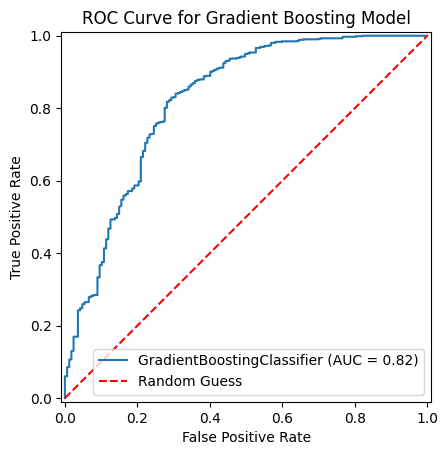

In [13]:
# weighted gradient boosting 
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_auc_score



# Plot the ROC curve
RocCurveDisplay.from_estimator(best_model, X_valid, y_valid)

# Add the "random guess" line (50/50 chance)
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Add title and labels
plt.title('ROC Curve for Gradient Boosting Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# regular gradient boosting

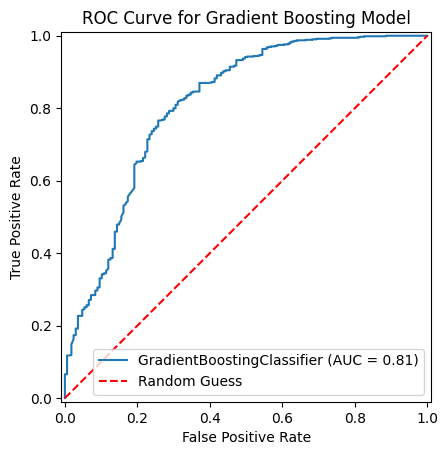

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# regular gradient boosting model

# Plot the ROC curve
RocCurveDisplay.from_estimator(best_model, X_valid, y_valid)

# Add the "random guess" line (50/50 chance)
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Add title and labels
plt.title('ROC Curve for Gradient Boosting Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


### The Gradient Boosting model's curve is also rising well, showing it's a good classifier. Based on its AUC score of 0.81, it is a strong model that performs much better than a random guess. And for weighted gradient boosting the score is similar which is 0.82 shows both the model performed similar. So, based on the score, Gradient Boosting and weighted gradient boosting performed pretty well, though not quite as effectively as AdaBoost.

# ada boost

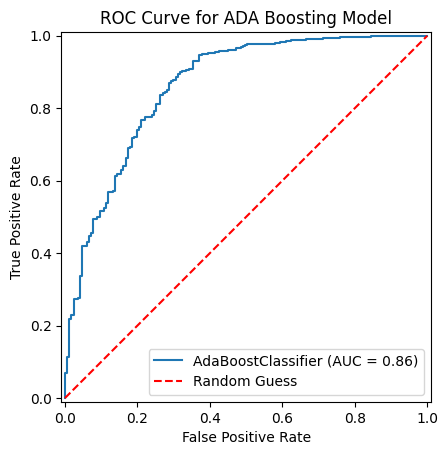

In [127]:


# best model  ada boost

# Plot the ROC curve
RocCurveDisplay.from_estimator(best_ada, X_valid, y_valid)

#  Add the "random guess" line (50/50 chance)
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

#  Add title and labels
plt.title('ROC Curve for ADA Boosting Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


### As we can see, the AdaBoost curve would be the highest and closest to the top-left corner. Its AUC score of 0.85 is the strongest of the three. This indicates it's the best model in this comparison, providing the most reliable balance of finding true delays without creating an excessive number of false alarms.

# decision tree

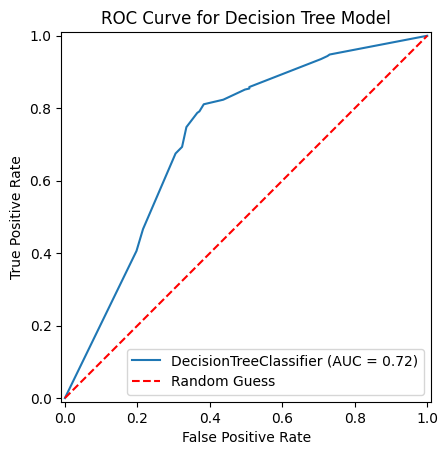

In [128]:
# best model decision tree

# Plot the ROC curve
RocCurveDisplay.from_estimator(best_tree, X_valid, y_valid)

# Add the "random guess" line (50/50 chance)
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

#  Add title and labels
plt.title('ROC Curve for Decision Tree Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



### The Decision Tree's curve would be the lowest of the three. Its AUC score of 0.72, while still clearly better than a 0.5 guess, is the weakest in this group. This score shows that the single tree has decent predictive power, but it struggles to separate the "on-time" and "delayed" classes as effectively as the more advanced boosting methods.

### The best metric for "balance between precision and recall" is the F1-Score. Looking at classification reports for the "delayed" class (class 0):

AdaBoost: F1-Score = 0.67

Single Decision Tree: F1-Score = 0.55

Gradient Boosting: F1-Score = 0.55

Conclusion: The AdaBoost model provides the best balance between precision and recall. It has the highest F1-Score for the "delayed" class (0.67), significantly outperforming the other two models.

## Part 5. Robustness and Scenario Exploration

Redefine a “delay” as an arrival at least 30 minutes late. Rebuild your boosted model.

How does this change model accuracy, recall, and class imbalance?

Imagine you added weather or carrier data.

Which new variables might most improve predictive performance, and why?

If the cost of misclassifying a delayed flight increased from 5× to 10×, how would you modify your modeling or evaluation strategy?

# utilized external source for preprocessing data below 

In [130]:
# Define the helper function 
# This converts 1455 (HHMM) into 895 (total minutes)
def time_to_minutes(time_hhmm):
    hours = time_hhmm // 100
    minutes = time_hhmm % 100
    return (hours * 60) + minutes

# Use the function to create the new column 

# Convert both time columns to minutes
crs_dep_mins = df['CRS_DEP_TIME'].apply(time_to_minutes)
dep_mins = df['DEP_TIME'].apply(time_to_minutes)

# Calculate the delay
# (This also fixes the 'past midnight' problem)
delay = dep_mins - crs_dep_mins
delay = delay.apply(lambda x: x + 1440 if x < -360 else x) 

# Create the new status column based on a 30-minute delay
df['New_Flight_Status'] = np.where(delay >= 30, 0, 1) # 0 = delayed, 1= ontime

# Check the result 
print("New class distribution (1= ontime, 0 = delayed):")
print(df['New_Flight_Status'].value_counts())



New class distribution (1= ontime, 0 = delayed):
New_Flight_Status
1    1971
0     230
Name: count, dtype: int64


In [131]:
X= pd.get_dummies(df.drop(columns=['Flight Status','New_Flight_Status']), drop_first=True)
y=df['New_Flight_Status']

In [132]:
X_train, X_valid, y_train, y_valid=train_test_split(X,y, test_size=0.4, random_state=1)

In [ ]:
gb_clf_new = GradientBoostingClassifier(random_state=1)

# Define parameter grid
param_grid = {
    'n_estimators': [70,75,80,85,90],
    'learning_rate': [0.08,0.09, 0.1,0.11, 0.12],
    'max_depth': [3,4, 5, 6]
}

# Grid Search CV
grid_search_new = GridSearchCV(
    estimator=gb_clf_new,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_search_new.fit(X_train, y_train)

# Evaluate best model
best_model_new = grid_search_new.best_estimator_
y_pred_new = best_model_new.predict(X_valid)

print("Best Hyperparameters:")
print(grid_search_new.best_params_)
print("\nTest Set Classification Report:")
print(classification_report(y_valid, y_pred_new))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters:
{'learning_rate': 0.09, 'max_depth': 7, 'n_estimators': 80}

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76        92
           1       0.96      0.99      0.98       789

    accuracy                           0.96       881
   macro avg       0.93      0.82      0.87       881
weighted avg       0.96      0.96      0.95       881



### the model accuracy compared to previous gradient boosting increased drammatically to 96 percent 

### the recall also improved for overall everything previously the recall was 55 percent for gradient boosting and now it is 65 percent which even got better than ADA boost. 

### the class imbalance become more severe, 19 percent to 10 percent but the model accuracy and recall accuracy increased. 

### the weather will increase model accuracy more because usually if there is a bad weather all the flights are automatically delayed on that day in general. Most of the flights have to be extra careful while flying during a bad weather 

### carrier data will improve the flight delay prediction but not as much as weather because just identify one airline and it doesnt represent all of the airline while weather affect all of the airlines 

### If the cost of misclassifying a delayed flight increased from 5× to 10× then we should focus on evaluation strategy because usually features are not being affected and only the weightage on delayed flight has increased. We can just adjust the cut off to get the adjusted outcome so delayed flight has more weight on it. 

## Part 6. Reflection and Communication

Short answer (100–150 words each):

In your own words, explain what “boosting” means and why it can reduce bias and variance.

Identify one limitation of your current analysis and propose how you would address it if given more data or time.

Summarize your findings for an airline operations manager with no data science background. Focus on actionable insights (e.g., when or why delays are most likely).

# Answer :
Boosting trains tiny decision trees. Each one learns from the last one’s mistakes. Together they spot patterns a single tree would miss (lower “bias”) and, by averaging many small trees, they’re less jumpy (lower “variance”).

Some fields (exact date, aircraft tail number) let the model “memorize” quirks instead of learning general rules. Also, delays are the minority. I’d turn dates into simple calendar clues (month/weekday/holiday), replace raw IDs with past-performance averages, use fairer train/test splits, and add richer weather details.

According to the top five predictors, departure time strongly influences whether a flight will be delayed. Airports are often busier at certain hours, which increases the likelihood of delays. The day of the month also matters—travel tends to spike around holidays, leading to congestion. Distance is another factor: longer flights face more opportunities for disruption, so their delay variability is typically higher.